<img src="img/Logo_OpenClassrooms.png" width=100 />

# OpenClassrooms Projet 5: Segmentez des clients d'un site e-commerce
# Modélisation

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


# Sommaire
### [Bibliothèques](#bibli)
### [Fonctions](#funcs)
### [Données](#donnees)
### [Centrage des données](#scaling)
### [Analyse en composantes principales](#PCA)
### [t-SNE](#tsne)
### [k-Means](#kmeans)
- [concordance k-Means, t-SNE](#concordance)

### [Tuning t-SNE](#tuning_tsne)
## V2
### [Données](#donnees_2)
### [Centrage des données](#scaling_2)
### [Analyse en composantes principales](#PCA_2)
### [t-SNE](#tsne_2)
### [k-Means](#kmeans_2)
- [concordance k-Means, t-SNE](#concordance_2)

### [Tuning t-SNE](#tuning_tsne_2)

### [DBSCAN](#DBSCAN_)
### [Clustering Hierarchique](#hierarchique)
### [Choix du modèle](#choix)
### [Stabilité](#stabilite)

<a id='bibli'></a>
# Import de bibliothèques 📚

In [1]:
import pandas as pd

pd.set_option("mode.chained_assignment", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib setup 
plt.style.use('seaborn')
plt.rcParams["image.cmap"] = 'Accent'

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestCentroid

import mlflow

import time

from functions import *

In [2]:
import data_prep
import datetime

<a id='funcs'></a>

# Fonctions ⚙️

In [3]:
def scree_plot(data_scale, savefig=False):
    pca_scree = decomposition.PCA(n_components=data_scale.shape[1])
    pca_scree.fit(data_scale)
    plt.style.use('fivethirtyeight')
    plt.xlabel('Nb de Composantes Principales')
    plt.ylabel('Pourcentage de variance expliquée (cumulée)')
    plt.title('Scree plot PCA')
    plt.plot(np.arange(1, pca_scree.n_components_ + 1), pca_scree.explained_variance_ratio_.cumsum()*100, color='#8c704d')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

<a id='plot_spyder'></a>

In [4]:
def plot_spyder(pca, feature_names, lim=0.6, savefig=False):
    pcs = pca.components_
    plt.figure(figsize=(12,12))
    for i,(x,y) in enumerate(zip(pcs[0,:], pcs[1,:])):
        plt.plot([0,x], [0,y], color='purple')
        plt.text(x,y, feature_names[i], fontsize='18')
        plt.axis('equal')
    plt.plot([-lim,lim], [0,0], color='grey', ls='--')
    plt.plot([0,0], [-lim,lim], color='grey', ls='--')
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.title('Spyder Plot')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()

<a id='plot_scatter_tsne'></a>

In [5]:
def plot_scatter_tsne(data_tsne, loaded_model, data_scale, savefig=False):
    """Create figure with 2d projected data by tsne colored 
    by labels predicted by a kmeans model"""
    x = [point[0] for point in data_tsne]
    y = [point[1] for point in data_tsne]

    fig, ax = plt.subplots(figsize=(8,8))
    plt.axis('equal')
    plt.rcParams["image.cmap"] = 'Accent'
    scatter = ax.scatter(x, y, marker='o', s=15, c=loaded_model.predict(pd.DataFrame(data_scale)))
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="best", title="Classes", fontsize=12)
    ax.add_artist(legend1)
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()
    print(tsne.kl_divergence_)

In [6]:
def plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale, savefig=False):
    """Create figure with 2d projected data by tsne colored 
    by labels predicted by a kmeans model"""
    
    df_subset = pd.DataFrame(data=data_tsne, columns=['x', 'y'])
    plt.figure(figsize=(8,8))
    plt.rcParams["image.cmap"] = 'Accent'
    
    plt.axis('equal')
    try:
        sns.scatterplot(x="x", 
                        y="y",
                        s=15,
                        hue=loaded_model.predict(pd.DataFrame(data_scale)),
                        palette=sns.color_palette("hls", len(set(loaded_model.labels_))),
                        data=df_subset,
                        legend="full")
    except Exception as e:
        sns.scatterplot(x="x", 
                        y="y",
                        s=15,
                        hue=loaded_model.fit_predict(pd.DataFrame(data_scale)),
                        palette=sns.color_palette("hls", len(set(loaded_model.labels_))),
                        data=df_subset,
                        legend="full")
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()
    print(tsne.kl_divergence_)

Retour au [code](#plot_scatter_tsne_back)

<a id='plot_perplexity_tsne'></a>

In [7]:
def plot_perplexity_tsne(tsne_data_save, 
                         loaded_model, 
                         data_scale,
                         color_from_labels=False, 
                         savefig=False):
    """"""
    fig, axes = plt.subplots(2,5, figsize=(25,10))
    axs = {5 : axes[0,0],
           10: axes[0,1],
           15: axes[0,2],
           20: axes[0,3],
           25: axes[0,4],
           30: axes[1,0],
           35: axes[1,1],
           40: axes[1,2],
           45: axes[1,3],
           50: axes[1,4]}
    for perplexity in np.arange(5,55,5):
        data_tsne_test = tsne_data_save[perplexity]
        df_subset = pd.DataFrame(data=data_tsne_test, columns=['x', 'y'])
        x = [point[0] for point in data_tsne_test]
        y = [point[1] for point in data_tsne_test]
        ax = axs[perplexity]
        ax.axis('equal')
        if color_from_labels:
            sns.scatterplot(ax=ax,
                            s=10,
                            x="x", 
                            y="y", 
                            hue=loaded_model.predict(pd.DataFrame(data_scale)),
                            palette=sns.color_palette("hls", len(set(list(loaded_model.predict(pd.DataFrame(data_scale)))))),
                            data=df_subset,
                            legend=False)
        else:
            ax.scatter(x, y, marker='.', s=10, 
                       color='purple')
        
        ax.set_title("Perplexity = {}".format(perplexity))
        ax.axis('equal')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

Retour au [code](#tuning_tsne)

<a id='launch_kmeans'></a>

In [8]:
def launch_kmeans(data, params, run_name):
    
    with mlflow.start_run(run_name=run_name):
        #Create an estimator
        model = KMeans(**params)
        #Save params
        for param, value in model.get_params().items():
            mlflow.log_param(param, value)
        #Fit
        start = time.time()
        model.fit(data)
        elapsed = time.time() - start
        
        
        #Save metrics
        mlflow.log_metric('inertia', model.inertia_)
        mlflow.log_metric('nb_iter', model.n_iter_)
        mlflow.log_metric('training_time', elapsed)
        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
        
        
        #Save model
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.end_run()
        
        return model

Retour au [code](#kmeans)

In [9]:
def plot_n_clust_against_metric(runs_df, metric, savefig=False):
    plt.style.use('fivethirtyeight')
    runs['params.n_clusters'] = runs['params.n_clusters'].astype('int')
    runs_df = runs_df.sort_values('params.n_clusters')
    plt.plot(runs_df['params.n_clusters'], runs_df[f'metrics.{metric}'], color='#59564c')
    
    metric_nice = metric.replace('_', ' ').capitalize()
    plt.title(f'{metric_nice} selon le nb de clusters')
    plt.xlabel('Nb de clusters')
    plt.ylabel(metric_nice)
    plt.xticks(runs_df['params.n_clusters'])
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()

<a id='donnees'></a>

# Données 🎁

<img src="img/structure.png" width=500 />

Les données ont été travaillées pour etre rassemblées dans une base propre ayant pour index les ids des clients ayant fait 2 commandes ou plus. Les varaiables ont été crées pour représenter leurs comportemenst, leur satisfactions et leurs expériences

In [141]:
data = pd.read_csv("data/customer_data_v_5.csv", index_col=[0])

In [142]:
data.head()

,nb_orders,sum_orders,average_review_score,average_delivery_time,cash,credit_card,voucher,arts_and_craftmanship,auto,baby,...,food_drink,furniture,health_beauty,home_confort,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,6,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,3,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,1,69.00,3.0,26,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,20,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,13,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
data.shape

(96096, 23)

In [144]:
data.columns

Index(['nb_orders', 'sum_orders', 'average_review_score',
       'average_delivery_time', 'cash', 'credit_card', 'voucher',
       'arts_and_craftmanship', 'auto', 'baby', 'culture', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys'],
      dtype='object')

In [145]:
cols_numeric = ['nb_orders', 'sum_orders', 'average_review_score',
               'average_delivery_time']
cols_categ = ['cash', 'credit_card', 'voucher',
       'arts_and_craftmanship', 'auto', 'baby', 'culture', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys']

<a id='scaling'></a>
# Centrage des données 📊

D'après la théorie de l'analyse en composante principale, pour pouvoir projeter nos données dans une base orthonormée de plus faible dimension alors la matrice des données doit être normée elle aussi

In [146]:
scaler = StandardScaler()

In [147]:
scaler.fit(data[cols_numeric])

StandardScaler()

In [148]:
scaler.transform(data[cols_numeric]).shape

(96096, 4)

In [149]:
data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), index=data.index, columns=cols_numeric), data[cols_categ]], axis=1)

In [150]:
data_scale

,nb_orders,sum_orders,average_review_score,average_delivery_time,cash,credit_card,voucher,arts_and_craftmanship,auto,baby,...,food_drink,furniture,health_beauty,home_confort,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.162368,-0.053119,0.687482,-0.652806,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.162368,-0.564134,-0.051377,-0.972545,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,-0.162368,-0.333486,-0.790235,1.478787,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,-0.162368,-0.531493,-0.051377,0.839309,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,-0.162368,0.177529,0.687482,0.093252,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,-0.162368,6.576725,0.687482,1.691947,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
fffea47cd6d3cc0a88bd621562a9d061,-0.162368,-0.352408,-0.051377,1.905106,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ffff371b4d645b6ecea244b27531430a,-0.162368,-0.237268,0.687482,0.306411,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<a id='PCA'></a>
# Analyse en composantes principales ☘️

Sans les données catégoriques

In [151]:
pca_simple = decomposition.PCA(n_components=3)
pca_simple.fit(data_scale[cols_numeric])
print(pca_simple.explained_variance_ratio_.cumsum())

[0.33150453 0.60676813 0.82899005]


Avec les données catégoriques

In [152]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.25287967 0.46294951 0.63268752]


On explique 63% de la variance avec trois composantes principales

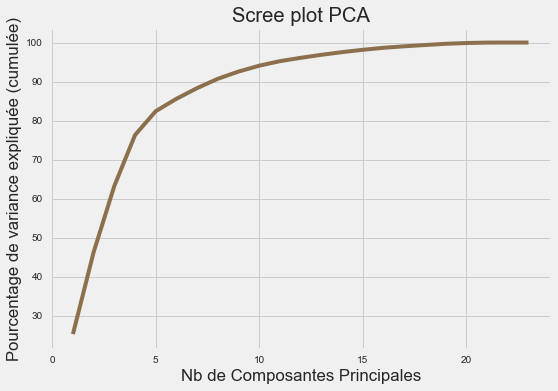

In [153]:
scree_plot(data_scale, savefig='scree_plot_v5')

Voir la [fonction plot_spyder](#plot_spyder)

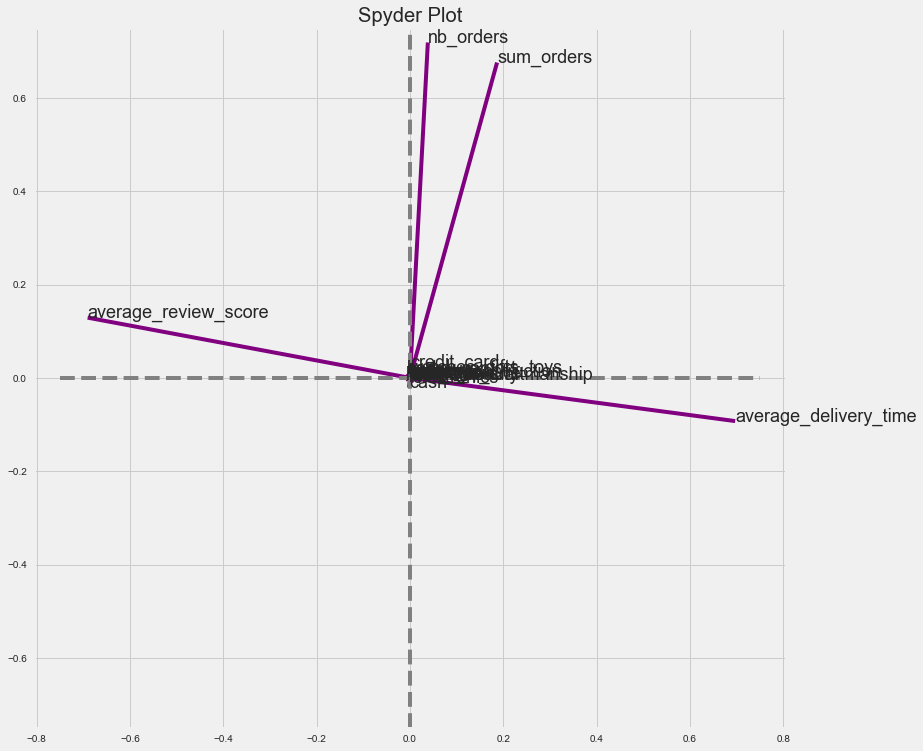

In [155]:
plot_spyder(pca, data_scale.columns, lim=0.75, savefig='spyder_plot_pca_v_5')

Retirer les features nb_orders, nb_reviews, sum_orders. On verra plus tard pour les catégories

In [156]:
pca = decomposition.PCA(n_components=12)
data_scale_decomp = pca.fit_transform(data_scale)

<a id='tsne'></a>
# t-SNE ✨

Données non standardisées

Données Standardisées

In [158]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1, perplexity=50)
data_tsne = tsne.fit_transform(data_scale_decomp)

Wall time: 15min 7s


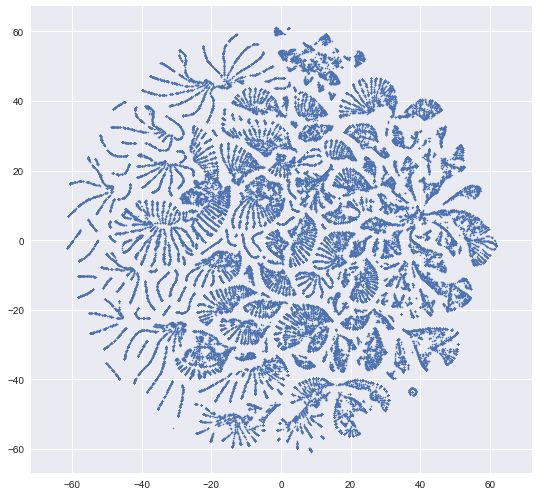

1.832024097442627


In [159]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

<a id='kmeans'></a>
# k-Means 🧶

In [28]:
mlflow.set_experiment('k_Means_5')

mlflow.set_experiment('k_Means')
for n_clusters in np.arange(19,26):
    launch_kmeans(data_scale, {'n_clusters':n_clusters, 'random_state':41}, 'GS_sil_db{}'.format(n_clusters))

Voir la [fonction](#launch_kmeans)

In [135]:
runs = mlflow.search_runs('10')

In [137]:
runs[runs['tags.mlflow.runName']=='tuning_n_clust'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score']].sort_values('metrics.silhouette_score', ascending=False)

,tags.mlflow.runName,params.n_clusters,metrics.inertia,metrics.silhouette_score
35,tuning_n_clust,4,270470.450334,0.387617
36,tuning_n_clust,3,316952.325978,0.379469
37,tuning_n_clust,2,394971.745691,0.350987
34,tuning_n_clust,5,240505.201613,0.324840
33,tuning_n_clust,6,218205.063526,0.245218
31,tuning_n_clust,8,188332.106761,0.239530
30,tuning_n_clust,9,180128.027221,0.239075
32,tuning_n_clust,7,201948.106576,0.234709
29,tuning_n_clust,10,172347.330120,0.202876
28,tuning_n_clust,11,166683.507443,0.194868


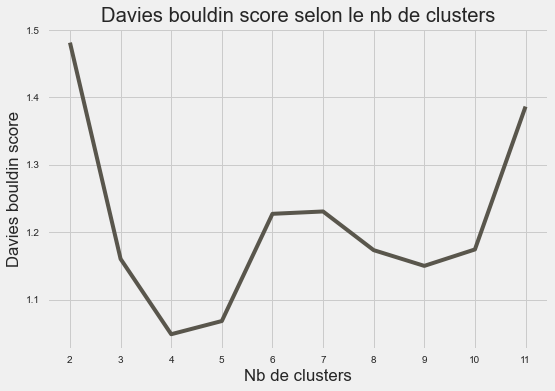

In [44]:
plot_n_clust_against_metric(runs, 'davies_bouldin_score', savefig='DB_v5_9clust')

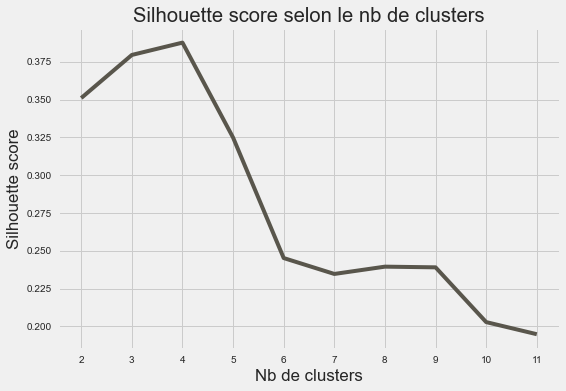

In [45]:
plot_n_clust_against_metric(runs, 'silhouette_score', savefig='S_v5_9clust')

In [30]:
runs.artifact_uri.iloc[0] + '/model'

'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/618a8111a0c54a999e258e3b3f7934b4/artifacts/model'

<a id='concordance'></a>
## Concordance k-Means avec t-SNE 🧬

### Avec 4 clusters

In [32]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/10/1c472e1cb8fa4709a432b6df5dd9db94/artifacts/model'


loaded_model = mlflow.sklearn.load_model(logged_model)

<a id='plot_scatter_tsne_back'></a>

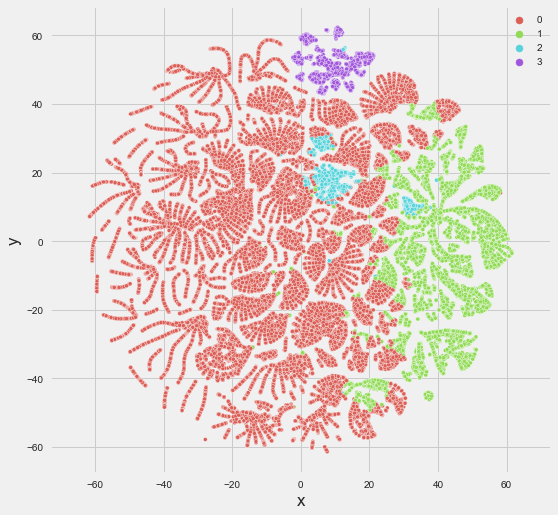

1.8887982368469238


In [33]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale_decomp)  

Voir [fonction](#plot_scatter_tsne)

In [34]:
pd.Series(loaded_model.predict(data_scale_decomp)).value_counts()

0    73387
1    17578
3     2963
2     2168
dtype: int64

### Avec 9 clusters

In [160]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/10/5ceb92803a774e0b9c6dbf48f9ebdd0d/artifacts/model'


loaded_model = mlflow.sklearn.load_model(logged_model)

<a id='plot_scatter_tsne_back'></a>

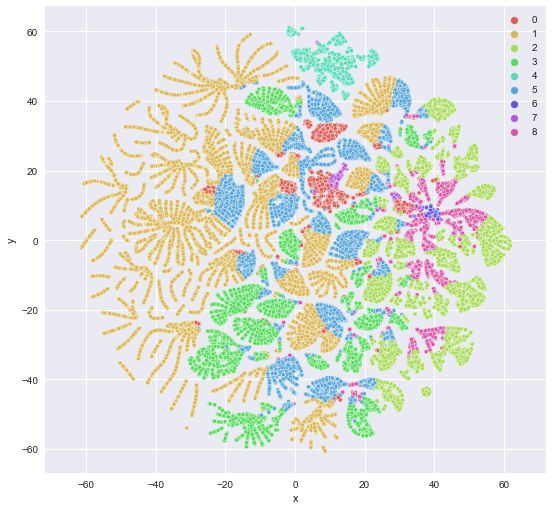

1.832024097442627


In [161]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale_decomp, savefig="tsne_kmeans_v5")  

Voir [fonction](#plot_scatter_tsne)

In [39]:
pd.Series(loaded_model.predict(data_scale_decomp)).value_counts()

1    40423
3    15546
5    14674
2    13954
8     4520
0     3306
4     2972
7      459
6      242
dtype: int64

<a id='DBSCAN_'></a>
# DBSCAN

In [90]:
def launch_dbscan(data, params, run_name):
    
    for eps in params['eps']:
        for min_samples in params['min_samples']:
            for metric in params['metric']:
                with mlflow.start_run(run_name=f'{run_name}_eps{eps}_ms{min_samples}_{metric}'):
                    #Create an estimator
                    model = DBSCAN(eps=eps,
                                   min_samples=min_samples,
                                   metric=metric,
                                   n_jobs=-1)
                    #Save params
                    for param, value in model.get_params().items():
                        mlflow.log_param(param, value)
                    #Fit
                    start = time.time()
                    model.fit(data)
                    elapsed = time.time() - start


                    #Save metrics
                    mlflow.log_metric('nb_clusters_found', len(set(model.labels_)) - (1 if -1 in model.labels_ else 0))
                    mlflow.log_metric('n_noise', list(model.labels_).count(-1))
                    mlflow.log_metric('training_time', elapsed)
                    try:
                        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
                    except:
                        pass
                    try:
                        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
                    except:
                        pass


                    #Save model
                    mlflow.sklearn.log_model(model, "model")

                    mlflow.end_run()

In [91]:
runs_dbscan = mlflow.search_runs('4')

In [92]:
runs_dbscan.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.training_time', 'metrics.nb_clusters_found',
       'metrics.davies_bouldin_score', 'metrics.n_noise',
       'metrics.silhouette_score', 'params.metric_params', 'params.leaf_size',
       'params.algorithm', 'params.eps', 'params.p', 'params.metric',
       'params.min_samples', 'params.n_jobs', 'tags.mlflow.source.name',
       'tags.mlflow.user', 'tags.mlflow.log-model.history',
       'tags.mlflow.source.type', 'tags.mlflow.runName'],
      dtype='object')

In [93]:
runs_dbscan = runs_dbscan[[
                         'metrics.silhouette_score', 
                         'metrics.n_noise',
                         'metrics.davies_bouldin_score',
                         'metrics.nb_clusters_found',
                         'params.eps',
                         'params.min_samples',
                         'params.metric'
                         ]]

In [94]:
runs_dbscan.groupby('params.metric').mean()

,metrics.silhouette_score,metrics.n_noise,metrics.davies_bouldin_score,metrics.nb_clusters_found
params.metric,,,,
cosine,-0.176827,1017.922222,2.161986,12.400000
euclidean,-0.317881,2621.388889,1.632956,30.833333
l2,-0.317881,2621.388889,1.632956,30.833333
manhattan,-0.360208,2878.544444,1.535519,20.833333


In [95]:
runs_dbscan.groupby('params.metric').max()

,metrics.silhouette_score,metrics.n_noise,metrics.davies_bouldin_score,metrics.nb_clusters_found,params.eps,params.min_samples
params.metric,,,,,,
cosine,0.332675,2997.0,4.502299,280.0,1,8
euclidean,-0.108780,2997.0,2.221724,289.0,1,8
l2,-0.108780,2997.0,2.221724,289.0,1,8
manhattan,-0.223024,2997.0,1.979317,289.0,1,8


In [96]:
runs_dbscan.groupby('params.metric').min()

,metrics.silhouette_score,metrics.n_noise,metrics.davies_bouldin_score,metrics.nb_clusters_found,params.eps,params.min_samples
params.metric,,,,,,
cosine,-0.515927,0.0,0.730150,0.0,0.0001,10
euclidean,-0.516103,506.0,1.208698,0.0,0.0001,10
l2,-0.516103,506.0,1.208698,0.0,0.0001,10
manhattan,-0.515457,1359.0,1.250044,0.0,0.0001,10


Quel modele chosir?

In [97]:
'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/4/a220d43fee794b50a298c6701947c647/artifacts/model'

'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/4/a220d43fee794b50a298c6701947c647/artifacts/model'

In [98]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/4/a220d43fee794b50a298c6701947c647/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_stacked_dbscan_10 = mlflow.sklearn.load_model(logged_model)

C:\Users\S053567\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DBSCAN from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [99]:
loaded_model_stacked_dbscan_10.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

<a id='plot_scatter_tsne_back'></a>

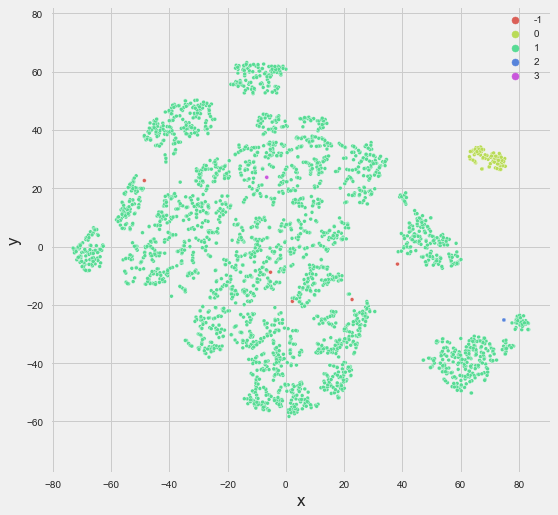

1.127383828163147


In [100]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_stacked_dbscan_10, data_scale_decomp) 

<a id='hierarchique'></a>
# Clustering Hierarchique

In [37]:
def launch_hierarchical_clustering(data, params, run_name):
    
    for n_clusters in params['n_clusters']:
        for linkage in params['linkage']:
            for affinity in params['affinity']:
                if affinity != 'euclidean' and linkage == "ward":
                    break
                with mlflow.start_run(run_name=f'{run_name}_nclust_{n_clusters}_aff_{affinity}_link_{linkage}'):
                    #Create an estimator


                    model = AgglomerativeClustering(n_clusters=n_clusters,
                                                    affinity=affinity,
                                                    linkage=linkage,
                                                    )
                    #Save params
                    for param, value in model.get_params().items():
                        mlflow.log_param(param, value)
                    #Fit
                    start = time.time()
                    model.fit(data)
                    elapsed = time.time() - start


                    #Save metrics


                    mlflow.log_metric('training_time', elapsed)
                    mlflow.log_metric('n_leaves', model.n_leaves_)
                    try:
                        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
                    except:
                        pass
                    try:
                        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
                    except:
                        pass


                    #Save model
                    mlflow.sklearn.log_model(model, "model")

                    mlflow.end_run()

In [38]:
params = {'n_clusters':np.arange(2,30),
          'linkage':['ward', 'complete', 'average', 'single'],
          'affinity':['cosine', 'l2', 'manhattan', 'euclidean']}
mlflow.set_experiment('Aggl_Clust')
launch_hierarchical_clustering(data_scale_decomp, params, 'v2')

MemoryError: unable to allocate array data.

In [39]:
model = AgglomerativeClustering(n_clusters=8,
                                affinity='manhattan',
                                linkage='single',
                                compute_distances=True).fit(data_scale_decomp)

In [42]:
pd.Series(model.labels_).value_counts()

1    96084
0        6
2        1
3        1
4        1
5        1
6        1
7        1
dtype: int64

In [163]:
model_agg_10 = AgglomerativeClustering(n_clusters=9,
                                affinity='manhattan',
                                linkage='single',
                                compute_distances=True).fit(data_scale_decomp)

In [164]:
pd.Series(model_agg_10.labels_).value_counts()

0    96084
1        5
2        1
3        1
4        1
5        1
6        1
7        1
8        1
dtype: int64

<a id='plot_scatter_tsne_back'></a>

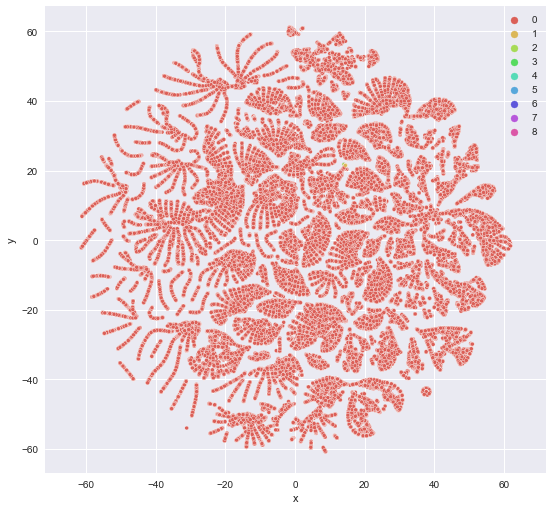

1.832024097442627


In [165]:
plot_scatter_tsne_seaborn(data_tsne, model_agg_10, data_scale_decomp, savefig='hierarchique_9')  

Voir [fonction](#plot_scatter_tsne)

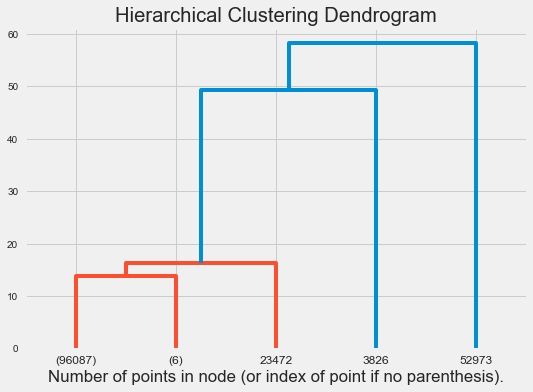

In [43]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

La méthode hierarchique est peu satisfaisante

<a id='choix'></a>
# Choix modèle

D'après les modélisations précédentes on peut choisir le modèle K-Means (4 clusters) après un PCA de 18 composantes

Nous appelerons la fonction ci dessous pour récupérer le modèle entrainé avec les données voulues

In [10]:
def pipeline_final(data, 
                   cols_categ, 
                   cols_numeric, 
                   n_clusters=9,
                   mode='model',
                   run_name=None,
                   experiment_name='pca_k_Means'):
    
    # FAIRE DOCSTRING
    scaler = StandardScaler().fit(data[cols_numeric])
    
    data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), 
                                         index=data.index, columns=cols_numeric), 
                            data[cols_categ]],
                           axis=1)
    pca = decomposition.PCA(n_components=12)
    data_scale_decomp = pca.fit_transform(data_scale)
    if mode == 'model':
        params = {'n_clusters':n_clusters, 'random_state':41}
        mlflow.set_experiment(experiment_name)
        model = launch_kmeans(data_scale_decomp, 
                              params, 
                              run_name)
        return model
    elif mode == 'data_process':
        return data_scale_decomp
    elif mode == 'data_labeled':
        params = {'n_clusters':n_clusters, 'random_state':41}
        mlflow.set_experiment(experiment_name)
        model = launch_kmeans(data_scale_decomp, 
                              params, 
                              run_name)
        cluster_labels = model.predict(data_scale_decomp)
        labeled_data = pd.DataFrame(data_scale, index=data.index, columns=data.columns)
        labeled_data["cluster"] = cluster_labels
        return labeled_data

<a id='stabilite'></a>
# Test de la stabilité 
Determination de la fréquence de mise à jour du clustering

In [11]:
orders = pd.read_csv('data/olist_orders_dataset.csv', index_col='order_id',parse_dates=['order_purchase_timestamp', 
                                                                                        'order_approved_at',	
                                                                                        'order_delivered_carrier_date',	
                                                                                        'order_delivered_customer_date',
                                                                                        'order_estimated_delivery_date'])

In [12]:
orders.order_purchase_timestamp.max() - pd.Timedelta('180 days')

Timestamp('2018-04-20 17:30:18')

In [13]:
orders.order_purchase_timestamp.max()

Timestamp('2018-10-17 17:30:18')

In [79]:
virtual_dates = pd.date_range(pd.Timestamp(2018, 4, 30),
                               orders.order_purchase_timestamp.max(), 
                               freq='SM',
                               normalize=True)

In [80]:
virtual_dates

DatetimeIndex(['2018-04-30', '2018-05-15', '2018-05-31', '2018-06-15',
               '2018-06-30', '2018-07-15', '2018-07-31', '2018-08-15',
               '2018-08-31', '2018-09-15', '2018-09-30', '2018-10-15'],
              dtype='datetime64[ns]', freq='SM-15')

In [81]:
data_initial = pd.read_csv(f'data/timed_data_full/{str(virtual_dates.min().date())}.csv', index_col=[0])

In [84]:
data_initial.columns

Index(['nb_orders', 'sum_orders', 'average_review_score',
       'average_delivery_time', 'cash', 'credit_card', 'voucher',
       'arts_and_craftmanship', 'auto', 'baby', 'culture', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys'],
      dtype='object')

In [85]:
cols_categ = ['cash', 'credit_card', 'voucher',
       'arts_and_craftmanship', 'auto', 'baby', 'culture', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys']
cols_numeric = ['nb_orders', 'sum_orders', 'average_review_score',
       'average_delivery_time']

In [86]:
for n in range(2,15):
    pipeline_final(data_initial,
               cols_categ,
               cols_numeric,
               n_clusters=n,
               mode='model',
               run_name='model_initial_30_04_18',
                experiment_name='k_Means_5')

In [87]:
runs = mlflow.search_runs('10')

In [88]:
runs = runs[runs['tags.mlflow.runName']=='model_initial_30_04_18'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score', 'metrics.davies_bouldin_score']].sort_values('metrics.silhouette_score', ascending=False)

In [89]:
runs

,tags.mlflow.runName,params.n_clusters,metrics.inertia,metrics.silhouette_score,metrics.davies_bouldin_score
10,model_initial_30_04_18,4,176887.527530,0.409583,1.004741
11,model_initial_30_04_18,3,210709.078769,0.399797,1.089961
12,model_initial_30_04_18,2,270275.636627,0.369432,1.404044
9,model_initial_30_04_18,5,155183.690107,0.343962,1.018738
1,model_initial_30_04_18,13,96276.525493,0.289286,1.135867
0,model_initial_30_04_18,14,92333.787632,0.280610,1.218213
3,model_initial_30_04_18,11,106944.058939,0.264726,1.196400
7,model_initial_30_04_18,7,131866.693346,0.231171,1.178023
6,model_initial_30_04_18,8,125074.714064,0.229318,1.143017
8,model_initial_30_04_18,6,141855.035930,0.226800,1.231970


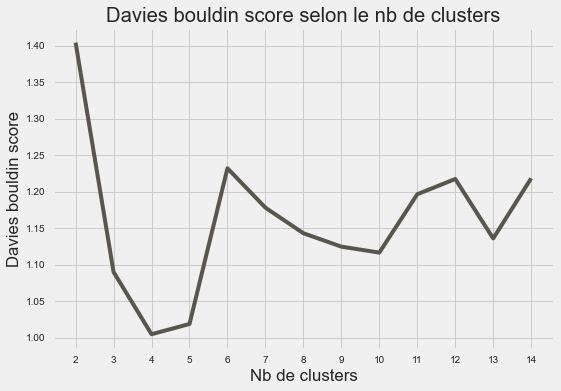

In [90]:
plot_n_clust_against_metric(runs, 'davies_bouldin_score', savefig=False)

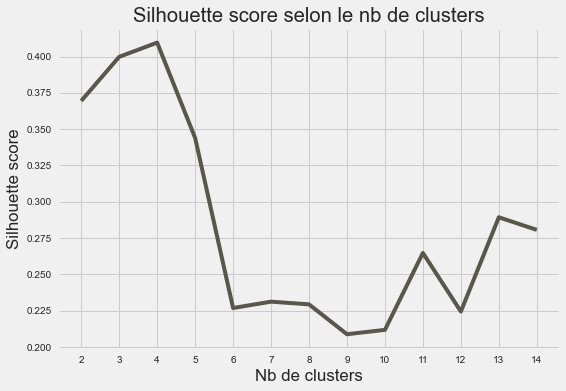

In [91]:
plot_n_clust_against_metric(runs, 'silhouette_score', savefig=False)

Pour ce dataset nous prendrons la configuration 11 clusters

In [92]:
virtual_dates

DatetimeIndex(['2018-04-30', '2018-05-15', '2018-05-31', '2018-06-15',
               '2018-06-30', '2018-07-15', '2018-07-31', '2018-08-15',
               '2018-08-31', '2018-09-15', '2018-09-30', '2018-10-15'],
              dtype='datetime64[ns]', freq='SM-15')

In [93]:
def test_stability_mono_model(virtual_dates, cols_categ, cols_numeric):
    
    first_data_set = pd.read_csv(f'data/timed_data_full/{str(virtual_dates.min().date())}.csv', index_col=[0])
    last_data_set = pd.read_csv(f'data/timed_data_full/{str(virtual_dates.max().date())}.csv', index_col=[0])
    print(first_data_set.shape)
    
    model = pipeline_final(first_data_set, 
                           cols_categ, 
                           cols_numeric, 
                           n_clusters=13,
                           mode='model',
                           run_name='stability_mono',
                           experiment_name='k_Means_5')
    

    output_data = pd.DataFrame(data=np.full([last_data_set.shape[0],1], np.nan), 
                               columns=[virtual_dates[0]], 
                               index=last_data_set.index)
    
    for virtual_date in virtual_dates:
        
        virtual_date_str = str(virtual_date.date())
        try:
            virtual_date_data = pd.read_csv(f'data/timed_data_full/{virtual_date_str}.csv', index_col=[0])
            print(virtual_date_data.shape)
            virtual_date_data_scale_decomp = pipeline_final(virtual_date_data,
                                                           cols_categ, 
                                                           cols_numeric, 
                                                           mode='data_process')
            serie_out = pd.Series(model.predict(virtual_date_data_scale_decomp),
                                  index=virtual_date_data.index,
                                  name=virtual_date)
            
            output_data = output_data.merge(serie_out, 
                                              how='left',
                                              left_index=True,
                                              right_index=True)
#             data_dict[virtual_date_str] = model.predict(virtual_date_data_scale_decomp)
            
        except Exception as e:
            print(e)
            print(str(virtual_date.date()))
    
    return output_data

data_stability = test_stability_mono_model(virtual_dates,cols_categ, cols_numeric)

(70954, 23)
(70954, 23)
(74929, 23)
(77680, 23)
(80659, 23)
(83629, 23)
(85883, 23)
(89505, 23)
(93724, 23)
(96089, 23)
(96094, 23)
(96095, 23)
(96095, 23)


In [94]:
data_stability

,2018-04-30 00:00:00_x,2018-04-30 00:00:00_y,2018-05-15 00:00:00,2018-05-31 00:00:00,2018-06-15 00:00:00,2018-06-30 00:00:00,2018-07-15 00:00:00,2018-07-31 00:00:00,2018-08-15 00:00:00,2018-08-31 00:00:00,2018-09-15 00:00:00,2018-09-30 00:00:00,2018-10-15 00:00:00
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,6.0,10.0,10.0,10.0,10.0,6.0,6.0,6.0,6.0,6,6
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,NaN,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11,11
0000f46a3911fa3c0805444483337064,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5
0000f6ccb0745a6a4b88665a16c9f078,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5
0004aac84e0df4da2b147fca70cf8255,NaN,6.0,10.0,6.0,6.0,6.0,6.0,10.0,10.0,10.0,10.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN,7.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0,3.0,3.0,3,3
fffea47cd6d3cc0a88bd621562a9d061,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5
ffff371b4d645b6ecea244b27531430a,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8,8


In [95]:
data_stability = data_stability.drop("2018-04-30 00:00:00_x", axis=1).rename({"2018-04-30 00:00:00_y":pd.Timestamp("2018-04-30 00:00:00")}, axis=1)

In [96]:
data_stability

,2018-04-30,2018-05-15,2018-05-31,2018-06-15,2018-06-30,2018-07-15,2018-07-31,2018-08-15,2018-08-31,2018-09-15,2018-09-30,2018-10-15
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,6.0,10.0,10.0,10.0,10.0,6.0,6.0,6.0,6.0,6,6
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11,11
0000f46a3911fa3c0805444483337064,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5
0000f6ccb0745a6a4b88665a16c9f078,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5
0004aac84e0df4da2b147fca70cf8255,6.0,10.0,6.0,6.0,6.0,6.0,10.0,10.0,10.0,10.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,7.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0,3.0,3.0,3,3
fffea47cd6d3cc0a88bd621562a9d061,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5
ffff371b4d645b6ecea244b27531430a,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8,8


In [97]:
len(data_stability.columns)

12

In [98]:
data_stability.columns

DatetimeIndex(['2018-04-30', '2018-05-15', '2018-05-31', '2018-06-15',
               '2018-06-30', '2018-07-15', '2018-07-31', '2018-08-15',
               '2018-08-31', '2018-09-15', '2018-09-30', '2018-10-15'],
              dtype='datetime64[ns]', freq=None)

In [100]:
data_stability.iloc[:,0:0+2].dropna()

,2018-04-30,2018-05-15
customer_unique_id,,
0000f46a3911fa3c0805444483337064,5.0,5.0
0000f6ccb0745a6a4b88665a16c9f078,5.0,5.0
0004aac84e0df4da2b147fca70cf8255,6.0,10.0
0004bd2a26a76fe21f786e4fbd80607f,8.0,8.0
00050ab1314c0e55a6ca13cf7181fecf,6.0,10.0
...,...,...
fffcc512b7dfecaffd80f13614af1d16,4.0,4.0
fffcf5a5ff07b0908bd4e2dbc735a684,7.0,7.0
fffea47cd6d3cc0a88bd621562a9d061,5.0,5.0


In [118]:
data_stability.iloc[:,[0,2+1]].dropna()

,2018-04-30,2018-06-15
customer_unique_id,,
0000f46a3911fa3c0805444483337064,5.0,5.0
0000f6ccb0745a6a4b88665a16c9f078,5.0,5.0
0004aac84e0df4da2b147fca70cf8255,6.0,6.0
0004bd2a26a76fe21f786e4fbd80607f,8.0,8.0
00050ab1314c0e55a6ca13cf7181fecf,6.0,6.0
...,...,...
fffcc512b7dfecaffd80f13614af1d16,4.0,4.0
fffcf5a5ff07b0908bd4e2dbc735a684,7.0,7.0
fffea47cd6d3cc0a88bd621562a9d061,5.0,5.0


In [114]:
ARI = []
AMI = []
for index_date in range(len(data_stability.columns) - 1):
    pair_comparison = data_stability.iloc[:,[0,index_date+1]].dropna()
    ARI.append(metrics.adjusted_rand_score(pair_comparison.iloc[:,0], pair_comparison.iloc[:,1]))
    AMI.append(metrics.adjusted_mutual_info_score(pair_comparison.iloc[:,0], pair_comparison.iloc[:,1]))
    

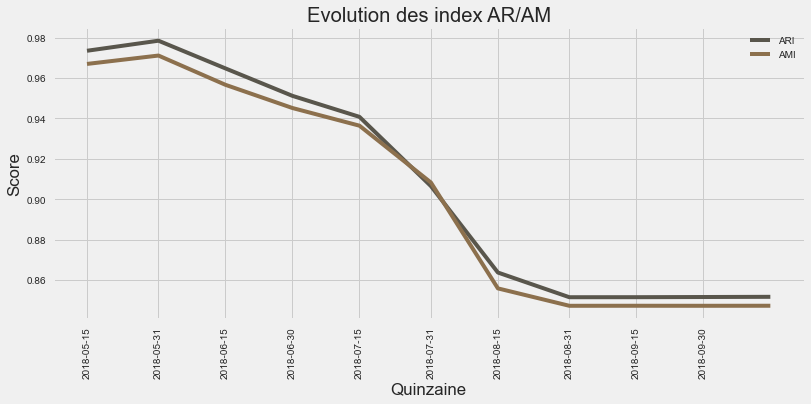

In [120]:
plt.figure(figsize=(12,5))
plt.title("Evolution des index AR/AM")
plt.plot(data_stability.columns[1:] , ARI, label='ARI', color="#59564c")
plt.plot(data_stability.columns[1:] , AMI, label='AMI', color='#8c704d')
plt.xticks(data_stability.columns[1:-1], rotation=90)
plt.xlabel('Quinzaine')
plt.ylabel('Score')
plt.legend()
plt.savefig('plots/ami_ari_v3.png', bbox_inches='tight', dpi=360)
plt.show()

In [123]:
mlflow.create_experiment('stability_multi_model_3')

'11'

In [127]:
def test_stability_multi_model(virtual_dates, cols_numeric, cols_categ):
    
    for virtual_date in virtual_dates:
        #Extraire données
        try:
            data_virtual_date = pd.read_csv(f'data/timed_data_full/{str(virtual_date.date())}.csv', index_col=[0])
        except:
            continue
        
        #Préparer données et lancer modele
        try:
            model = pipeline_final(data_virtual_date, 
                                   cols_categ, 
                                   cols_numeric, 
                                   n_clusters=13,
                                   mode='model',
                                   run_name=str(virtual_date.date()),
                                   experiment_name='stability_multi_model_3')
        except:
            continue
        
        
    #Stocker scores
    runs = mlflow.search_runs('11')

    return runs[['metrics.davies_bouldin_score', 'metrics.silhouette_score']]


In [128]:
runs_multi = test_stability_multi_model(virtual_dates, cols_numeric, cols_categ)

In [130]:
runs = mlflow.search_runs('11')
scores = runs[['tags.mlflow.runName', 'metrics.davies_bouldin_score', 'metrics.silhouette_score']]

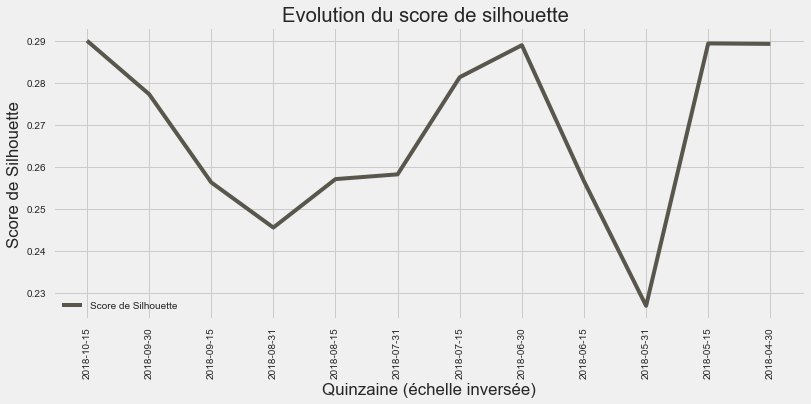

In [134]:
plt.figure(figsize=(12,5))
plt.title("Evolution du score de silhouette ")
plt.plot(scores['tags.mlflow.runName'] , scores['metrics.silhouette_score'], label='Score de Silhouette', color="#59564c")
plt.xticks(scores['tags.mlflow.runName'], rotation=90)
plt.xlabel('Quinzaine (échelle inversée)')
plt.ylabel('Score de Silhouette')
plt.legend()
plt.savefig('plots/stability_silhouette_3.png', bbox_inches='tight', dpi=360)
plt.show()

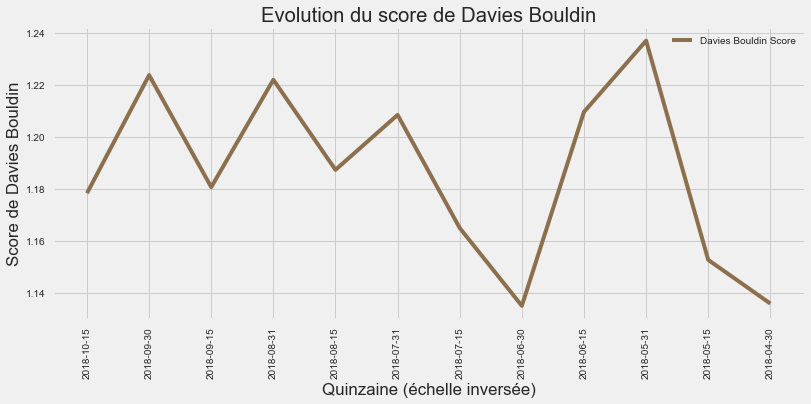

In [133]:
plt.figure(figsize=(12,5))
plt.title("Evolution du score de Davies Bouldin")
plt.plot(scores['tags.mlflow.runName'] , scores['metrics.davies_bouldin_score'], label='Davies Bouldin Score', color='#8c704d')
plt.xticks(scores['tags.mlflow.runName'], rotation=90)
plt.xlabel('Quinzaine (échelle inversée)')
plt.ylabel('Score de Davies Bouldin')
plt.legend()
plt.savefig('plots/stability_DB_3.png', bbox_inches='tight', dpi=360)
plt.show()

# Interpretation du dernier modèle

Fonctions issues du cours OC en anglais de Llewelyn Fernandes sur le K-Means

In [41]:
data_to_interpret = pd.read_csv(f'data/customer_data_v_5.csv', index_col=[0])

In [42]:
data_to_interpret.columns

Index(['nb_orders', 'sum_orders', 'average_review_score',
       'average_delivery_time', 'cash', 'credit_card', 'voucher',
       'arts_and_craftmanship', 'auto', 'baby', 'culture', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'industry', 'other', 'pet_shop', 'sports_leisure',
       'watches_gifts_toys'],
      dtype='object')

In [43]:
data_to_interpret.head()

,nb_orders,sum_orders,average_review_score,average_delivery_time,cash,credit_card,voucher,arts_and_craftmanship,auto,baby,...,food_drink,furniture,health_beauty,home_confort,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,6,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,3,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,1,69.00,3.0,26,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,20,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,13,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
labeled_data = pipeline_final(data_to_interpret, 
                               cols_numeric = cols_numeric,
                              cols_categ = cols_categ,
                               n_clusters=9,
                               mode='data_labeled',
                               run_name=None,
                               experiment_name='pca_k_Means')

In [46]:
labeled_data

,nb_orders,sum_orders,average_review_score,average_delivery_time,cash,credit_card,voucher,arts_and_craftmanship,auto,baby,...,furniture,health_beauty,home_confort,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys,cluster
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.162368,-0.053119,0.687482,-0.652806,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.162368,-0.564134,-0.051377,-0.972545,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,-0.162368,-0.333486,-0.790235,1.478787,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5
0000f6ccb0745a6a4b88665a16c9f078,-0.162368,-0.531493,-0.051377,0.839309,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
0004aac84e0df4da2b147fca70cf8255,-0.162368,0.177529,0.687482,0.093252,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,-0.162368,6.576725,0.687482,1.691947,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,7
fffea47cd6d3cc0a88bd621562a9d061,-0.162368,-0.352408,-0.051377,1.905106,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
ffff371b4d645b6ecea244b27531430a,-0.162368,-0.237268,0.687482,0.306411,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5


In [47]:
# cols_numeric = data_to_interpret.loc[:,:'cancelation_rate'].columns
cols_numeric_list = list(cols_numeric)
cols_numeric_list.append('cluster')
cols_numeric_index = pd.Index(cols_numeric_list)
# cols_categ = data_to_interpret.loc[:,'baby':].columns
cols_categ_list = list(cols_categ)
cols_categ_list.append('cluster')
cols_categ_index = pd.Index(cols_categ_list)

In [49]:
model = pipeline_final(data_to_interpret, 
                        cols_numeric = cols_numeric,
                                cols_categ = cols_categ,
                               n_clusters=9,
                               mode='model',
                               run_name=None,
                               experiment_name='pca_k_Means')

In [129]:
# # Create a data frame containing our centroids
# centroids = pd.DataFrame(model.cluster_centers_, columns=data_to_interpret.columns)
# centroids['cluster'] = model.labels_

# display_parallel_coordinates_centroids(centroids, 9, stagger=False)
# plt.xticks(rotation=90)
# # plt.savefig('plots/interpretation_categs.png', bbox_inches='tight', dpi=360)
# plt.show()

Problème : On ne peut pas interpreter les coordonnées des clusters sur l'espace réduit par le PCA. Il faut donc recalculer les centroïdes dans l'espace à 31 dimensions.

On ne peut pas non plus calculer les centroïdes des clusters tels quels car sklearn n'arrive pas à mélanger des données normalisées et les données binaires des catégories

In [50]:
clf_categ = NearestCentroid()
X_categ = labeled_data[cols_categ_index].drop(columns=['cluster'])
y_categ = labeled_data[cols_categ_index]['cluster']
clf_categ.fit(X_categ, y_categ)

NearestCentroid()

In [51]:
labeled_data[cols_categ_index].describe()

,cash,credit_card,voucher,arts_and_craftmanship,auto,baby,culture,electronics,fashion,food_drink,furniture,health_beauty,home_confort,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys,cluster
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,0.198125,0.773757,0.028107,0.025860,0.038930,0.029575,0.016379,0.155605,0.034590,0.009928,0.174534,0.119485,0.083573,0.054935,0.005703,0.017285,0.017274,0.075643,0.133668,2.508450
std,0.398589,0.418400,0.165280,0.158717,0.193429,0.169411,0.126930,0.362482,0.182741,0.099142,0.379570,0.324360,0.276747,0.227854,0.075301,0.130331,0.130293,0.264428,0.340297,1.952586
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [52]:
clf_numeric = NearestCentroid()
X_num = labeled_data[cols_numeric_index].drop(columns=['cluster'])
y_num = labeled_data[cols_numeric_index]['cluster']
clf_numeric.fit(X_num, y_num)

NearestCentroid()

In [53]:
labeled_data[cols_numeric_index].describe()

,nb_orders,sum_orders,average_review_score,average_delivery_time,cluster
count,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,96096.000000
mean,-1.892600e-15,8.168162e-18,-1.209519e-15,-6.875351e-18,2.508450
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.952586
min,-1.623683e-01,-6.511444e-01,-2.267952e+00,-2.038342e+00,0.000000
25%,-1.623683e-01,-4.394185e-01,-5.137658e-02,-6.528060e-01,1.000000
50%,-1.623683e-01,-2.414117e-01,6.874819e-01,-2.264873e-01,2.000000
75%,-1.623683e-01,5.783132e-02,6.874819e-01,3.064110e-01,3.000000
max,7.447054e+01,6.122310e+01,6.874819e-01,2.098287e+01,8.000000


In [54]:
cols_categ

['cash',
 'credit_card',
 'voucher',
 'arts_and_craftmanship',
 'auto',
 'baby',
 'culture',
 'electronics',
 'fashion',
 'food_drink',
 'furniture',
 'health_beauty',
 'home_confort',
 'home_construction',
 'industry',
 'other',
 'pet_shop',
 'sports_leisure',
 'watches_gifts_toys']

In [55]:
cols_numeric_index

Index(['nb_orders', 'sum_orders', 'average_review_score',
       'average_delivery_time', 'cluster'],
      dtype='object')

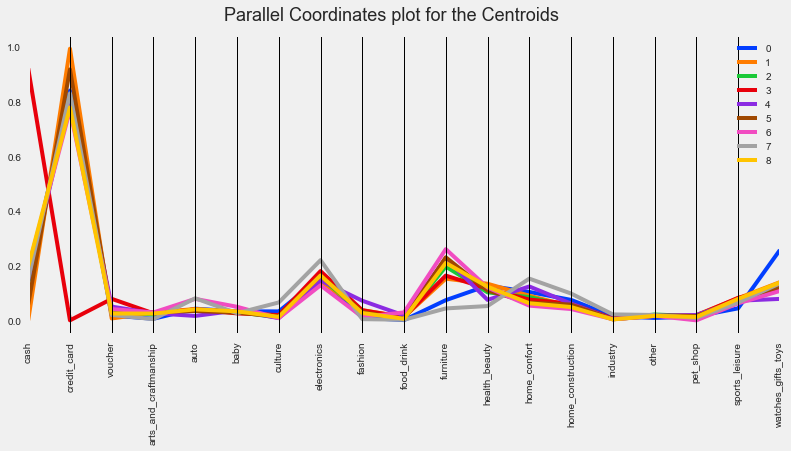

In [56]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(clf_categ.centroids_, columns=cols_categ)
centroids['cluster'] = clf_categ.classes_

display_parallel_coordinates_centroids(centroids, 4, stagger=False)
plt.xticks(rotation=90)
plt.savefig('plots/interpretation_categs_4.png', bbox_inches='tight', dpi=360)
plt.show()

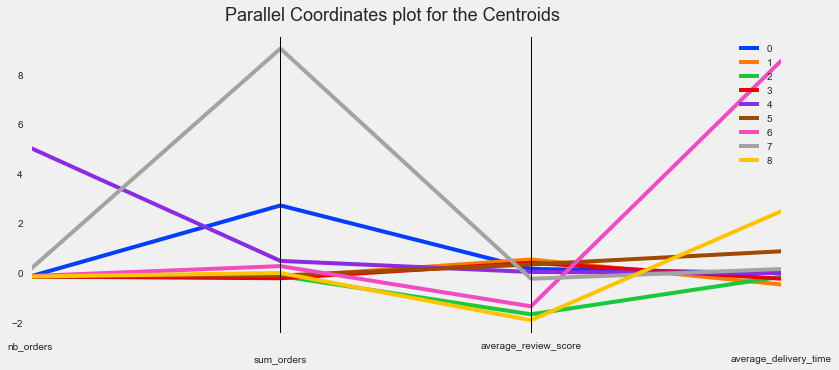

In [57]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(clf_numeric.centroids_, columns=cols_numeric)
centroids['cluster'] = clf_numeric.classes_

display_parallel_coordinates_centroids(centroids, 4)
plt.savefig('plots/interpretation_num_features_4.png', bbox_inches='tight', dpi=360)

In [58]:
labeled_data.cluster.value_counts(normalize=True)

1    0.420652
3    0.161776
5    0.152701
2    0.145209
8    0.047036
0    0.034403
4    0.030927
7    0.004776
6    0.002518
Name: cluster, dtype: float64

- Cluster 0 : Clients dépensiers, achats de petits produits. (Stars 3%)
- Cluster 1 : Clients 1 achats, statisfaits, carte bancaire, beauté/stanté (42%)
- Cluster 2 : Clients non satisfaits (15%)
- Cluster 3 : Clients payant par cash ou voucher, satisfaits (16%)
- Cluster 4 : Clients faisant le plus de commandes mais dépensant peu (3%)
- Cluster 5 : Clients difficiles à livrer mais satisfaits (15%)
- Cluster 6 : Clients très difficiles à livrer, plutot insatfisfaits, achats meubles (2%)
- Cluster 7 : Electronique, auto, maison : plus grosses dépenses (Stars 0.2%)
- Cluster 8 : Clients très insatisfaits et difficiles à livrer (0.4%)